# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

# Loading Datasets

In [4]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Preprocess and Save

### Load Preporcessed Dataset

In [56]:
# loading images
images_l = load_obj_real("list_ex")
images_l_1 = load_obj_real("list_ex_128")
images_l_2 = load_obj_real("list_ex_64")

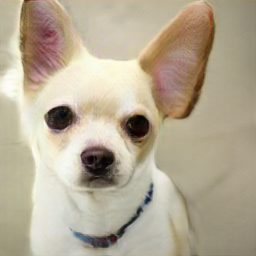

In [23]:
# Example image
images_l[4]

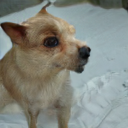

In [52]:
images_l_1[5]

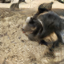

In [59]:
images_l_2[2]

## Real Images

In [8]:
dataroot_real = "data/data/SN_CATS_DOGS/"
dataset_real = dset.ImageFolder(root=dataroot_real)

In [21]:
# loading images
images_real = load_obj_real("list_ex_real")

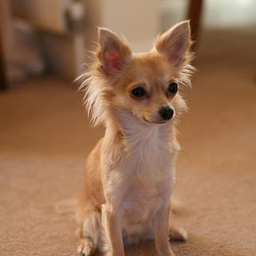

In [24]:
images_real[4]

# Analyzing Images

## Creating FFT

In [17]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [39]:
# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

### Generated Images

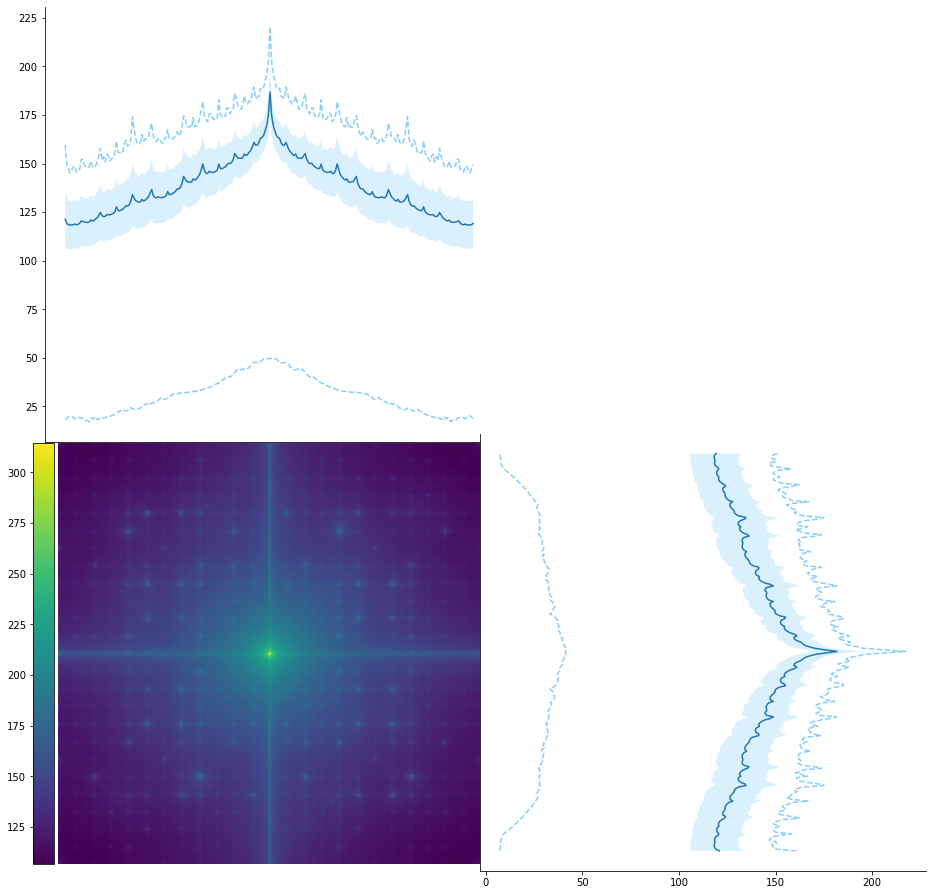

In [99]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g)

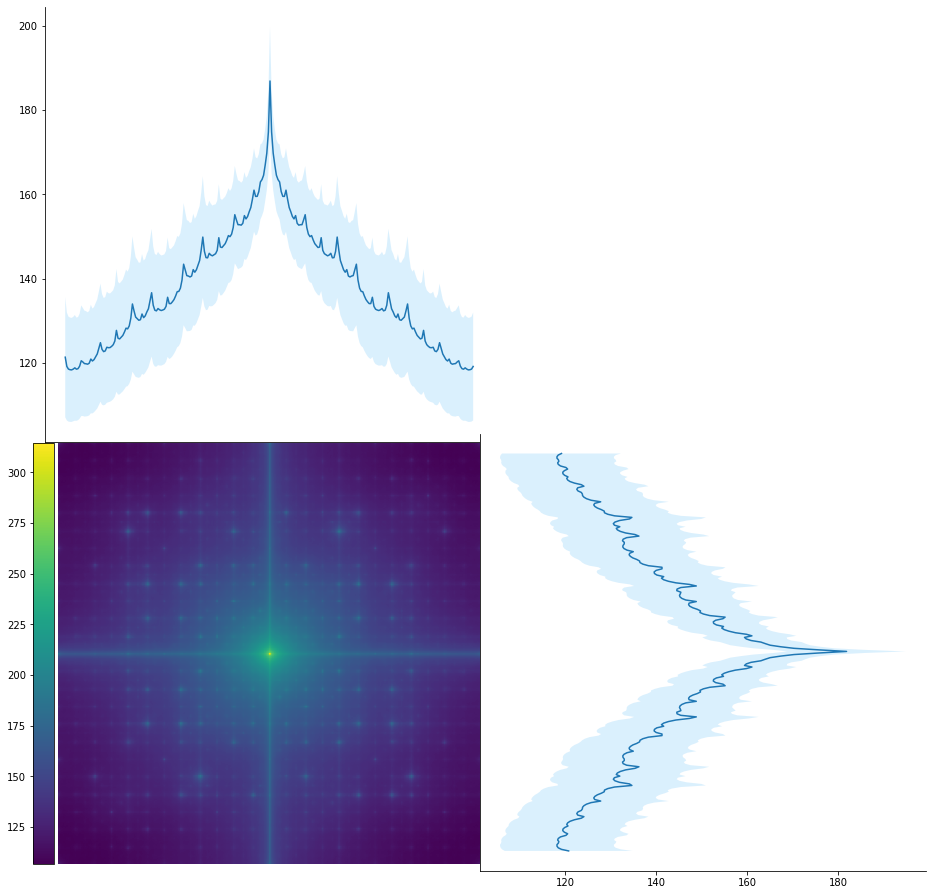

In [101]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Real Images

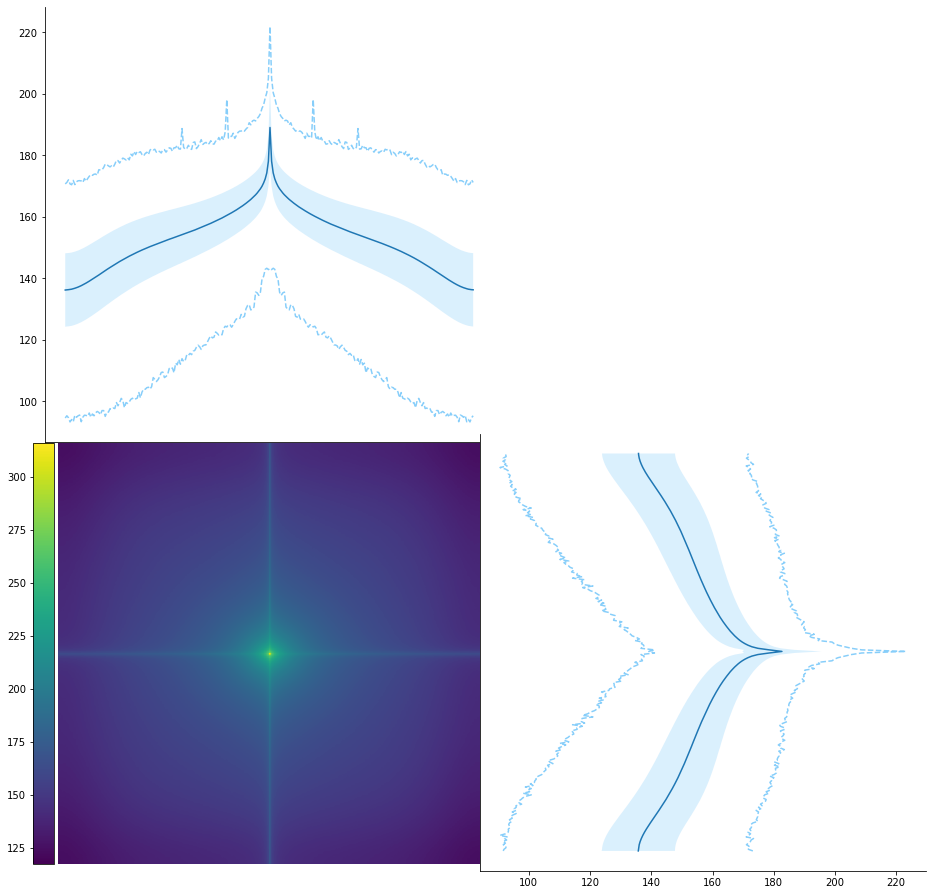

In [102]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

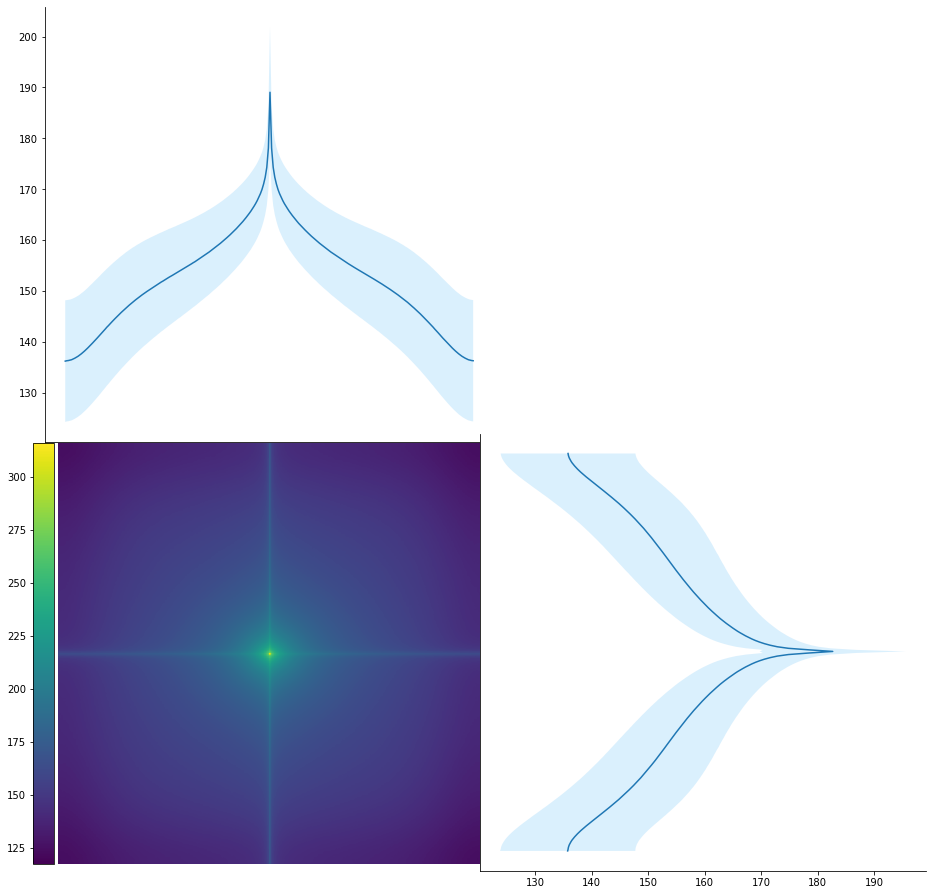

In [103]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Real vs Fake

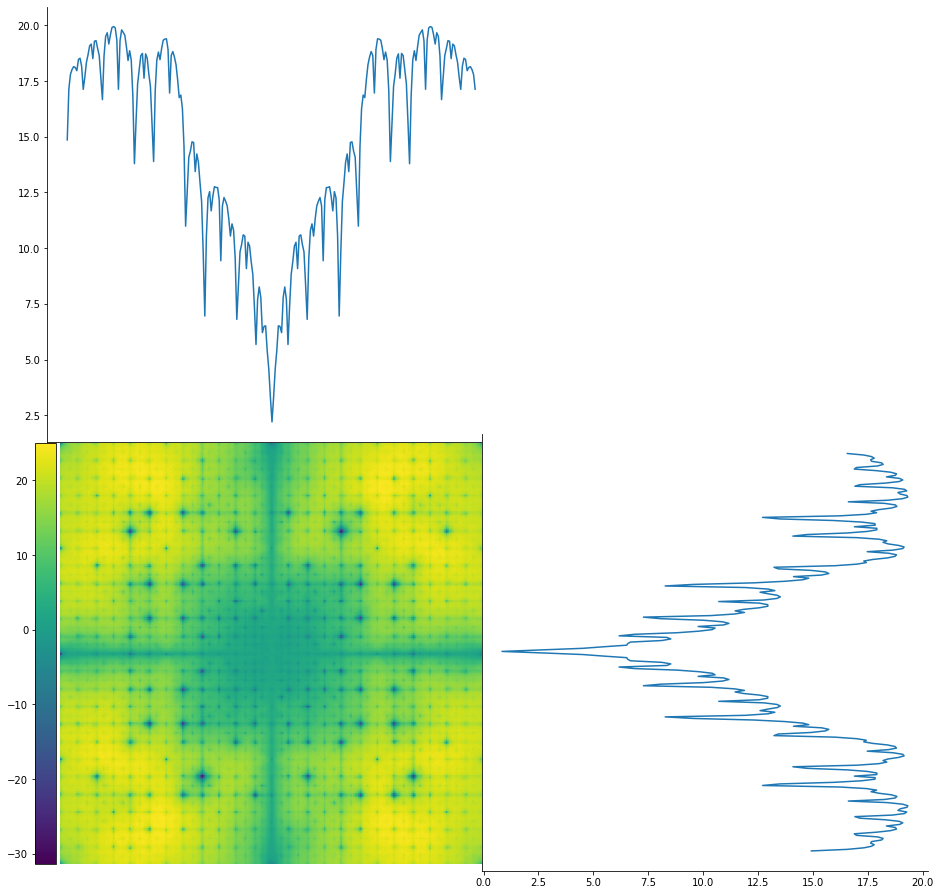

In [107]:
create_comparison_plot(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="SNGAN")

Text(0.5, 0.98, 'Comparison between Real and SNGAN - left: colomn wise right: row-wise')

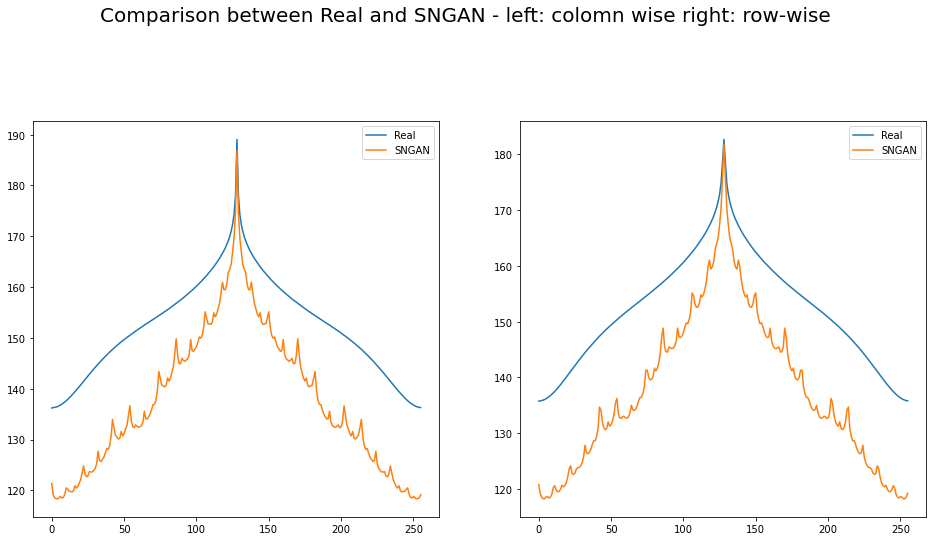

In [14]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g, label='SNGAN')
ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g, label='SNGAN')
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and SNGAN - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and SNGAN - left: colomn wise right: row-wise')

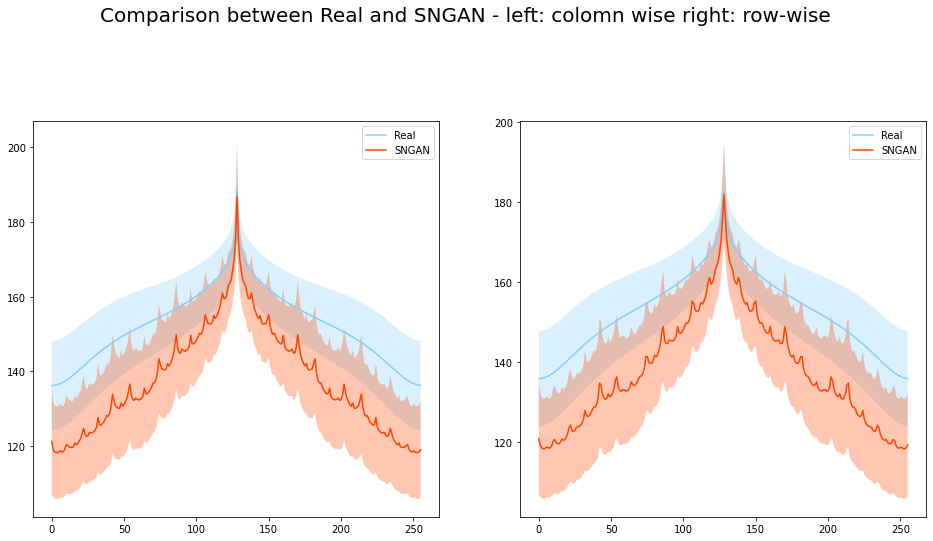

In [16]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.3)
ax1.plot(range(len(zero_axis_r)),zero_axis_g, label='SNGAN', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g + std_zero_axis_g, zero_axis_g -std_zero_axis_g,facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.3)
ax2.plot(range(len(one_axis_g)),one_axis_g, label='SNGAN',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g + std_one_axis_g, one_axis_g -std_one_axis_g,facecolor='orangered', alpha=0.3)
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and SNGAN - left: colomn wise right: row-wise", fontsize=20)

### Real vs Fake relative

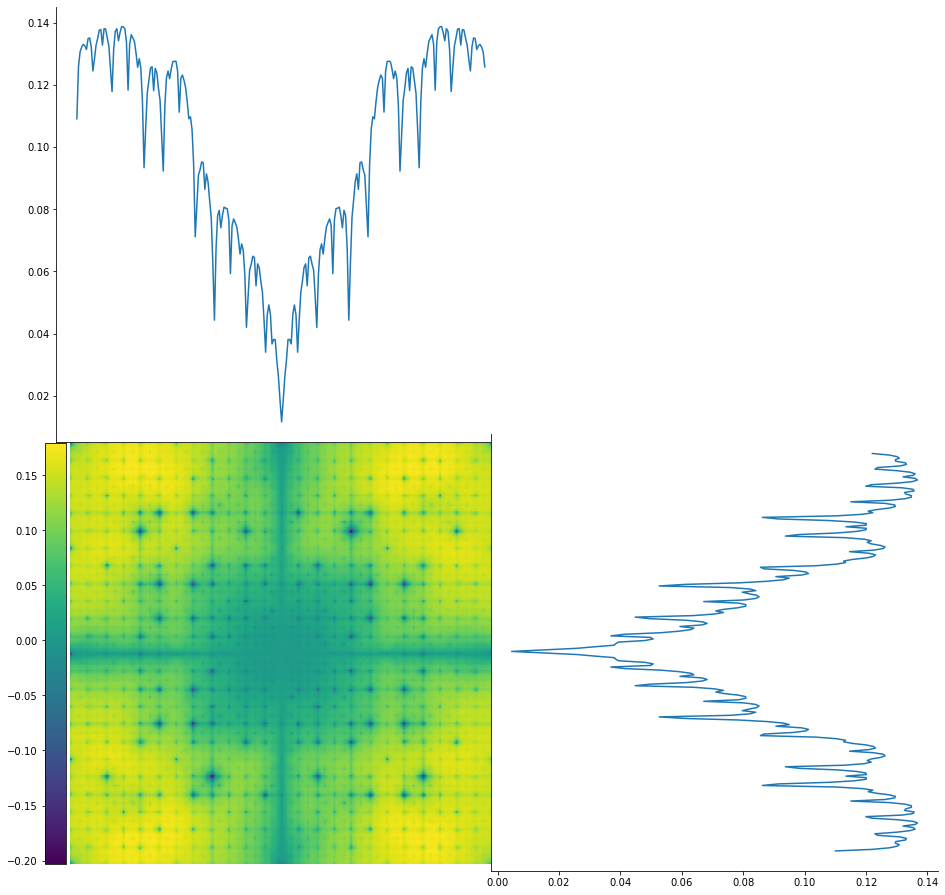

In [109]:
create_comparison_plot_rel(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="SNGAN")

# Size Comparison

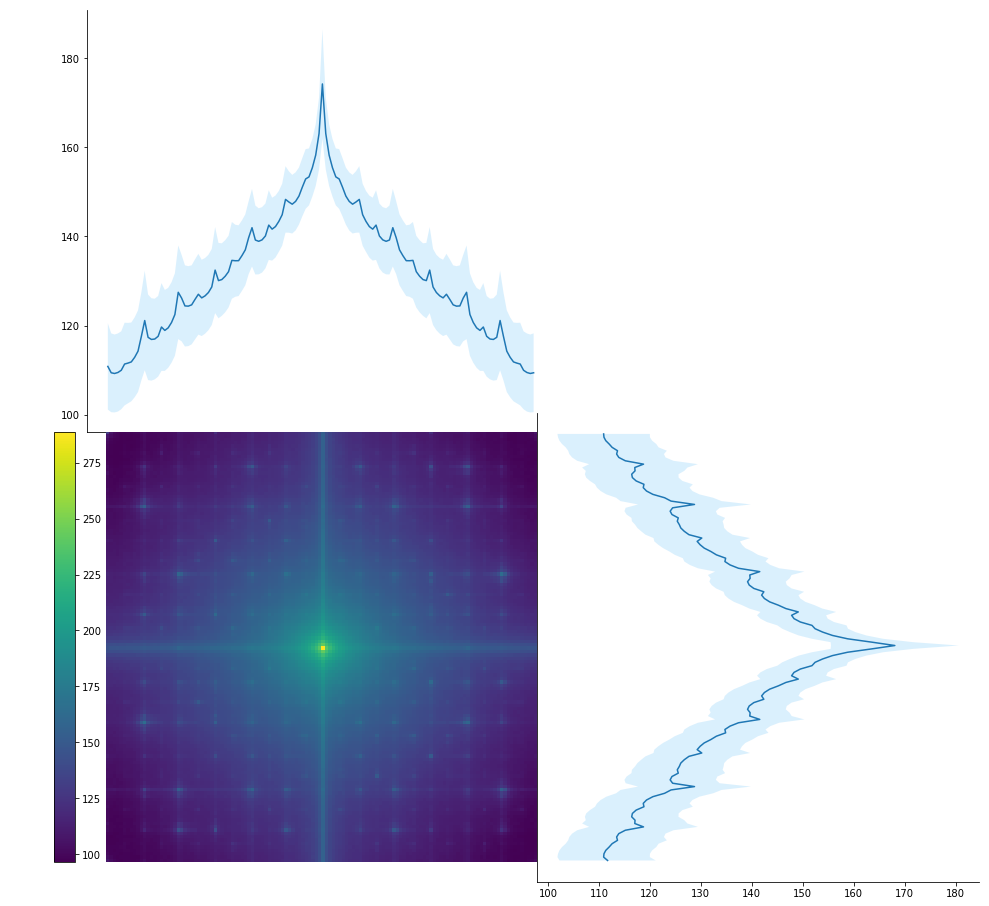

In [41]:
two_dim_g_1, zero_axis_g_1, one_axis_g_1, m_g_1, n_g_1,min_zero_axis_g_1,max_zero_axis_g_1, min_one_axis_g_1, max_one_axis_g_1, std_zero_axis_g_1, std_one_axis_g_1 = create_informations(images)
create_overview_plot(two_dim_g_1, zero_axis_g_1, one_axis_g_1, m_g_1, n_g_1,min_zero_axis_g_1,max_zero_axis_g_1, min_one_axis_g_1, max_one_axis_g_1, std_zero_axis_g_1, std_one_axis_g_1, max_min = False)

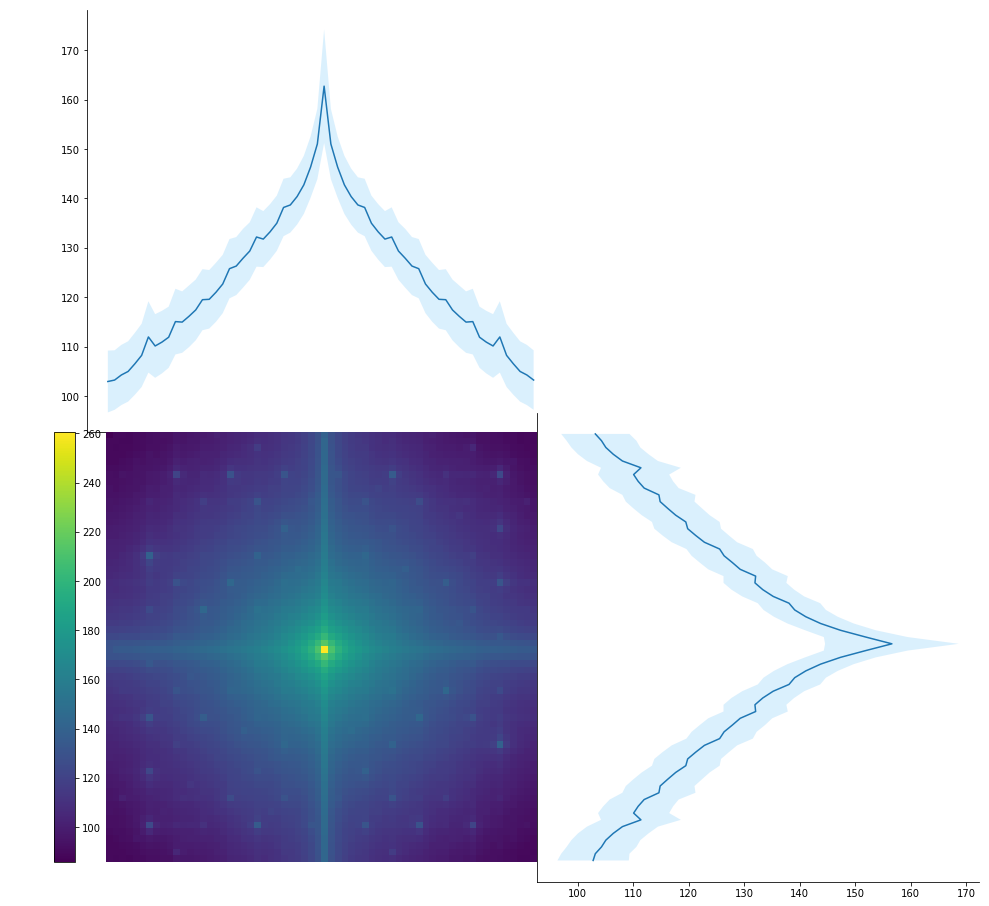

In [60]:
two_dim_g_2, zero_axis_g_2, one_axis_g_2, m_g_2, n_g_2,min_zero_axis_g_2,max_zero_axis_g_2, min_one_axis_g_2, max_one_axis_g_2, std_zero_axis_g_2, std_one_axis_g_2 = create_informations(images)
create_overview_plot(two_dim_g_2, zero_axis_g_2, one_axis_g_2, m_g_2, n_g_2,min_zero_axis_g_2,max_zero_axis_g_2, min_one_axis_g_2, max_one_axis_g_2, std_zero_axis_g_2, std_one_axis_g_2, max_min = False)